# Comparison of streamflow modelling of choosen citites between a standard Long Short-Term Memory Network (LSTM) and a combined Convolutional Neuronal Network with Long Short-Term Memory Network (CNNLSTM)

### This notebooks reproduces the results related to the abstract "Vorhersage von Zeitreihen durch Nutzung von Machine Learning-Ansätzen am Beispiel einer Niederschlagabflussmodellierug"

### Polat, Kadir und Salhi, Hamza: "Vorhersage von Zeitreihen durch Nutzung von Machine Learning-Ansätzen am Beispiel einer Niederschlagabflussmodellierug"

## Setup
#### Librarys and seperated functions which are used in this Notebook. In getData the data for the considered basin is loaded. In preProcess all important preprocessing Steps like scaling, preparing an appropriate shape and at least shuffling the data are included. In model the concrete network architecture, the compilation and loss calculation is defined. In postProcess the Nash–Sutcliffe model efficiency coefficient is calculated as well as essential model parameters.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scripts import getData
from scripts import preProcess  
from scripts import model 
from scripts import postProcess
from IPython.display import Image
import matplotlib.image as mpimg
# Download the dataset you need on following Websites
# Camels US Dataset: https://ral.ucar.edu/solutions/products/camels
# Daymet US Dataset: https://daac.ornl.gov/cgi-bin/dsviewer.pl?ds_id=1840

## Cities

### In the following image the US clima map can be seen. Especially the cities Seattle/Eureka/Mesa which are considered for the streamflow prediction are marked in this map. 

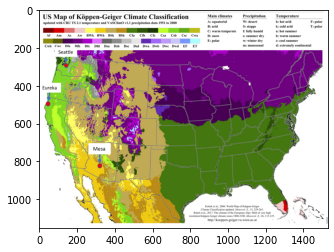

In [6]:
#Image(url= "US_clima_map.PNG")
plt.figure()
img = mpimg.imread('US_clima_map.PNG')
imgplot = plt.imshow(img)
plt.show()

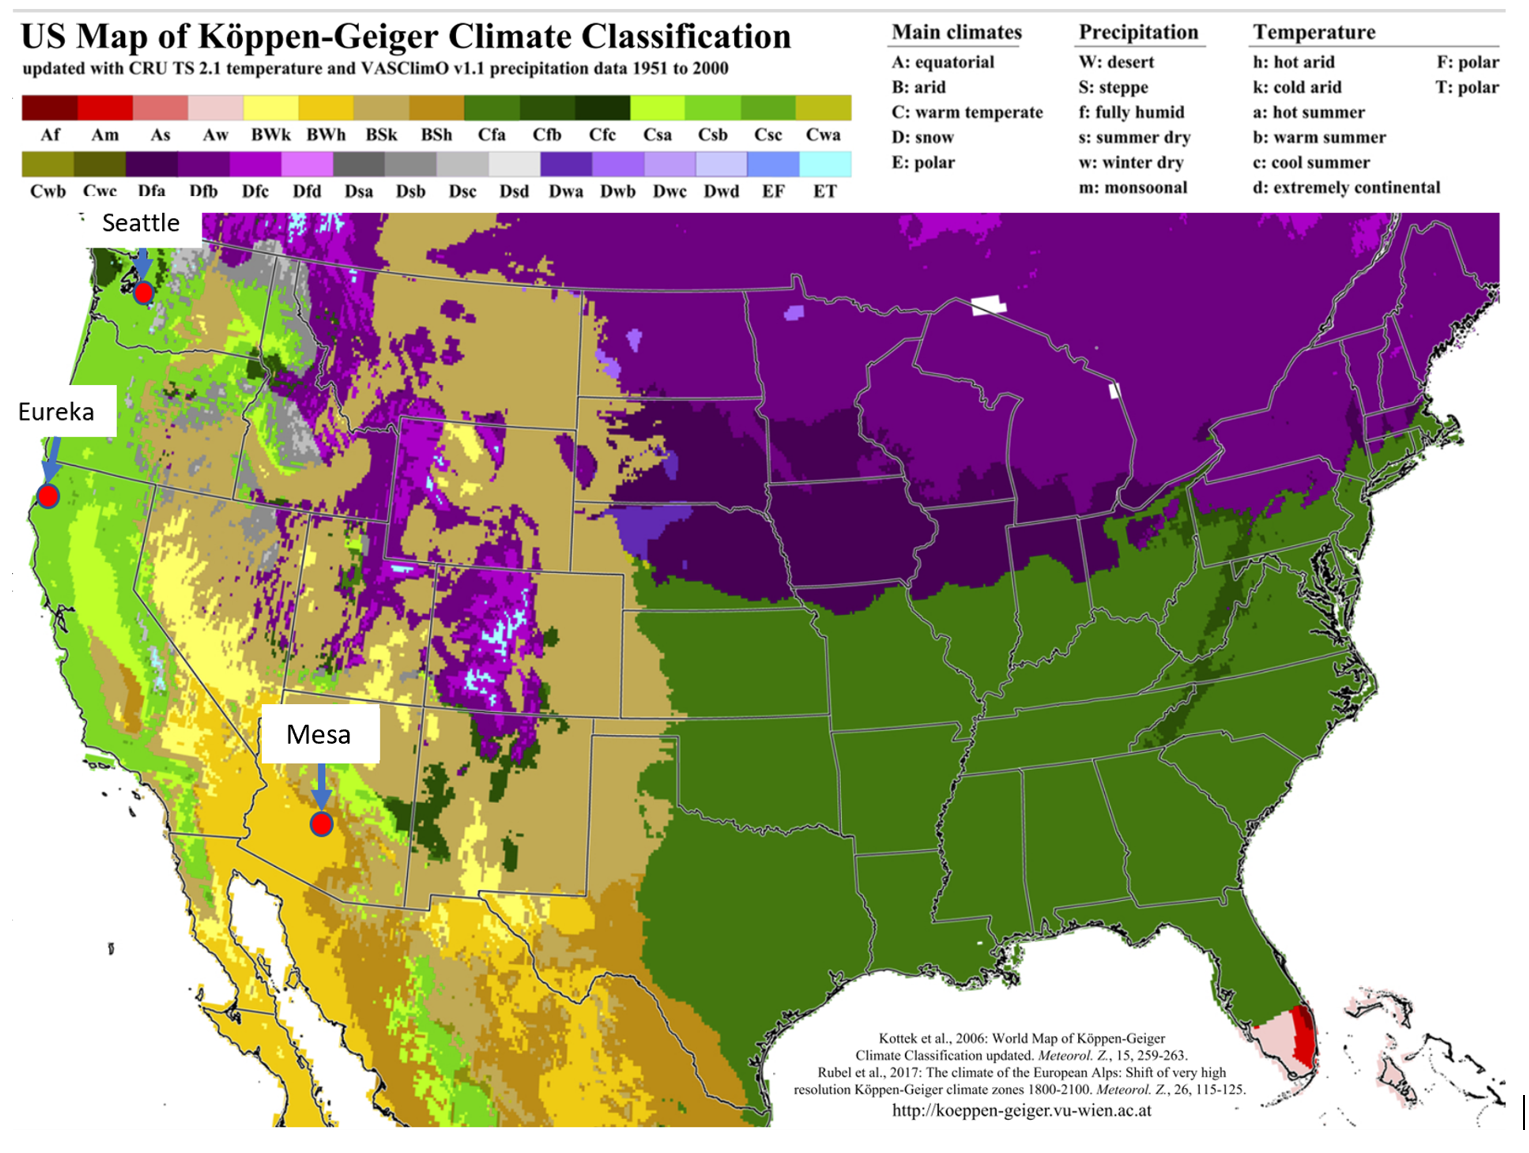

## Load Daymet Data for CNNLSTM
#### Loading the downloaded Daymet-US streamflow/forcing data and preprocess these. Daymet and Camels Dataset are differently build up. In this constellation the traindata includes 80% of the whole dataset. The evaluation and test dataset each include 10% of the whole dataset. In this case data from 1980 to 1996 is considered but can be changed by changing the start- and endyear variables. 50 days are used here to calculate the streamflow on day 50+1. Changing "days" for example to 30 would calculate the streamflow on day 30+1.

In [2]:
# Initialisierung der Daten
basin=[9494000,11522500,12189500] # Basin considered here: Mesa/Eureka/Seattle
startyear=1980 # startyear
endyear=1996 # endyear
days=50 # days to consider
wholeData,wholeStreamflow =getData.cnn_lstm_data(basin,startyear, endyear)

# Straemflow of all considerd basins
streamflow_9494000 = wholeStreamflow[0]
streamflow_11522500 = wholeStreamflow[1]
streamflow_12189500 = wholeStreamflow[2]

# Normierung
forcings_9494000, SF_forcings_9494000 = preProcess.scale(wholeData[0])
streamflow_9494000, SF_streamflow_9494000 = preProcess.scale(streamflow_9494000)
forcings_9494000,streamflow_9494000 = preProcess.prepareData(forcings_9494000,streamflow_9494000,days)
forcings_9494000,streamflow_9494000 = preProcess.shuffle(forcings_9494000,streamflow_9494000)

forcings_11522500, SF_forcings_11522500 = preProcess.scale(wholeData[1])
streamflow_11522500, SF_streamflow_11522500 = preProcess.scale(streamflow_11522500)
forcings_11522500,streamflow_11522500 = preProcess.prepareData(forcings_11522500,streamflow_11522500,days)
forcings_11522500,streamflow_11522500 = preProcess.shuffle(forcings_11522500,streamflow_11522500)

forcings_12189500, SF_forcings_12189500 = preProcess.scale(wholeData[2])
streamflow_12189500, SF_streamflow_12189500 = preProcess.scale(streamflow_12189500)
forcings_12189500,streamflow_12189500 = preProcess.prepareData(forcings_12189500,streamflow_12189500,days)
forcings_12189500,streamflow_12189500 = preProcess.shuffle(forcings_12189500,streamflow_12189500)

# Trainingsdaten
forcings_9494000_train = forcings_9494000[:round(forcings_9494000.shape[0]*0.8)]
streamflow_9494000_train = streamflow_9494000[:round(streamflow_9494000.shape[0]*0.8)]

forcings_11522500_train = forcings_11522500[:round(forcings_11522500.shape[0]*0.8)]
streamflow_11522500_train = streamflow_11522500[:round(streamflow_11522500.shape[0]*0.8)]

forcings_12189500_train = forcings_12189500[:round(forcings_12189500.shape[0]*0.8)]
streamflow_12189500_train = streamflow_12189500[:round(streamflow_12189500.shape[0]*0.8)]

# Evaluierungsdaten
forcings_9494000_eval= forcings_9494000[round(forcings_9494000.shape[0]*0.8):round(forcings_9494000.shape[0]*0.9)]
streamflow_9494000_eval= streamflow_9494000[round(streamflow_9494000.shape[0]*0.8):round(streamflow_9494000.shape[0]*0.9)]

forcings_11522500_eval= forcings_11522500[round(forcings_11522500.shape[0]*0.8):round(forcings_11522500.shape[0]*0.9)]
streamflow_11522500_eval= streamflow_11522500[round(streamflow_11522500.shape[0]*0.8):round(streamflow_11522500.shape[0]*0.9)]

forcings_12189500_eval= forcings_12189500[round(forcings_12189500.shape[0]*0.8):round(forcings_12189500.shape[0]*0.9)]
streamflow_12189500_eval= streamflow_12189500[round(streamflow_12189500.shape[0]*0.8):round(streamflow_12189500.shape[0]*0.9)]

# Testdaten
forcings_9494000_test= forcings_9494000[round(forcings_9494000.shape[0]*0.9):]
streamflow_9494000_test= streamflow_9494000[round(streamflow_9494000.shape[0]*0.9):]

forcings_11522500_test= forcings_11522500[round(forcings_11522500.shape[0]*0.9):]
streamflow_11522500_test= streamflow_11522500[round(streamflow_11522500.shape[0]*0.9):]

forcings_12189500_test= forcings_12189500[round(forcings_12189500.shape[0]*0.9):]
streamflow_12189500_test= streamflow_12189500[round(streamflow_12189500.shape[0]*0.9):]
del wholeData
del wholeStreamflow


# Train CNN-LSTM Models
#### Get model architecture, compile model and calculate loss.  Afterwards model is evaluated and based on testdata  output values are predicted. As input the shape of the considered and prepared basin is expected. The shape for the CNN-LSTM model contains Timesteps, x_shape, y_shape and features in this order. The shape for the LSTM model contains timesteps and features in this order. The batchsize which is in this case 64 and the number of epochs which is 100 can be changed for each mdoel separately.


### Mesa CNNLSTM

Epoch 1/100
63/63 [==============================] - 28s 443ms/step - loss: 0.0899 - mean_squared_error: 0.0899 - mean_absolute_error: 0.2395 - val_loss: 0.0741 - val_mean_squared_error: 0.0739 - val_mean_absolute_error: 0.2331
Epoch 2/100
63/63 [==============================] - 17s 276ms/step - loss: 0.0769 - mean_squared_error: 0.0769 - mean_absolute_error: 0.2205 - val_loss: 0.0633 - val_mean_squared_error: 0.0633 - val_mean_absolute_error: 0.1845
Epoch 3/100
63/63 [==============================] - 14s 224ms/step - loss: 0.0720 - mean_squared_error: 0.0720 - mean_absolute_error: 0.2101 - val_loss: 0.0602 - val_mean_squared_error: 0.0601 - val_mean_absolute_error: 0.1953
Epoch 4/100
63/63 [==============================] - 12s 189ms/step - loss: 0.0631 - mean_squared_error: 0.0631 - mean_absolute_error: 0.1972 - val_loss: 0.0583 - val_mean_squared_error: 0.0581 - val_mean_absolute_error: 0.1869
Epoch 5/100
63/63 [==============================] - 11s 173ms/step - loss: 0.0552 - mea

Epoch 37/100
63/63 [==============================] - 8s 121ms/step - loss: 0.0161 - mean_squared_error: 0.0161 - mean_absolute_error: 0.0907 - val_loss: 0.0162 - val_mean_squared_error: 0.0162 - val_mean_absolute_error: 0.0875
Epoch 38/100
63/63 [==============================] - 8s 120ms/step - loss: 0.0156 - mean_squared_error: 0.0156 - mean_absolute_error: 0.0887 - val_loss: 0.0153 - val_mean_squared_error: 0.0154 - val_mean_absolute_error: 0.0830
Epoch 39/100
63/63 [==============================] - 8s 120ms/step - loss: 0.0152 - mean_squared_error: 0.0152 - mean_absolute_error: 0.0878 - val_loss: 0.0158 - val_mean_squared_error: 0.0158 - val_mean_absolute_error: 0.0908
Epoch 40/100
63/63 [==============================] - 8s 120ms/step - loss: 0.0145 - mean_squared_error: 0.0145 - mean_absolute_error: 0.0863 - val_loss: 0.0168 - val_mean_squared_error: 0.0168 - val_mean_absolute_error: 0.0860
Epoch 41/100
63/63 [==============================] - 8s 120ms/step - loss: 0.0143 - mea

Epoch 73/100
63/63 [==============================] - 7s 119ms/step - loss: 0.0105 - mean_squared_error: 0.0105 - mean_absolute_error: 0.0722 - val_loss: 0.0128 - val_mean_squared_error: 0.0128 - val_mean_absolute_error: 0.0784
Epoch 74/100
63/63 [==============================] - 8s 119ms/step - loss: 0.0097 - mean_squared_error: 0.0097 - mean_absolute_error: 0.0702 - val_loss: 0.0118 - val_mean_squared_error: 0.0119 - val_mean_absolute_error: 0.0744
Epoch 75/100
63/63 [==============================] - 7s 119ms/step - loss: 0.0104 - mean_squared_error: 0.0104 - mean_absolute_error: 0.0726 - val_loss: 0.0137 - val_mean_squared_error: 0.0138 - val_mean_absolute_error: 0.0758
Epoch 76/100
63/63 [==============================] - 8s 120ms/step - loss: 0.0109 - mean_squared_error: 0.0109 - mean_absolute_error: 0.0742 - val_loss: 0.0130 - val_mean_squared_error: 0.0131 - val_mean_absolute_error: 0.0762
Epoch 77/100
63/63 [==============================] - 7s 119ms/step - loss: 0.0098 - mea

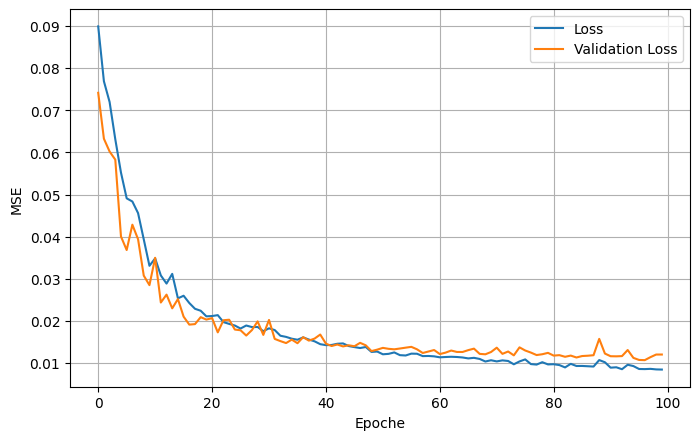

In [3]:
dnn_model_9494000 = model.model_CNN_LSTM(forcings_9494000.shape[1],forcings_9494000.shape[2],forcings_9494000.shape[3],
                                       forcings_9494000.shape[4])

history = model.kompilierung(model=dnn_model_9494000, inputs=forcings_9494000_train, targets=streamflow_9494000_train,
                          validation=(forcings_9494000_eval, streamflow_9494000_eval), batch_size=64, epochs=100)

model.loss(history)


# Evaluierung und Speichern der Metriken
dnn_results_9494000 = dnn_model_9494000.evaluate(forcings_9494000_test, streamflow_9494000_test)
# Vorhersage der auf den Testdaten
y_predicted_9494000 = dnn_model_9494000.predict(forcings_9494000_test)


### Eureka CNNLSTM

Epoch 1/100
63/63 [==============================] - 25s 402ms/step - loss: 0.0698 - mean_squared_error: 0.0698 - mean_absolute_error: 0.2023 - val_loss: 0.0511 - val_mean_squared_error: 0.0510 - val_mean_absolute_error: 0.1773
Epoch 2/100
63/63 [==============================] - 14s 226ms/step - loss: 0.0533 - mean_squared_error: 0.0533 - mean_absolute_error: 0.1749 - val_loss: 0.0511 - val_mean_squared_error: 0.0510 - val_mean_absolute_error: 0.1627
Epoch 3/100
63/63 [==============================] - 20s 318ms/step - loss: 0.0466 - mean_squared_error: 0.0466 - mean_absolute_error: 0.1615 - val_loss: 0.0374 - val_mean_squared_error: 0.0373 - val_mean_absolute_error: 0.1478
Epoch 4/100
63/63 [==============================] - 22s 343ms/step - loss: 0.0414 - mean_squared_error: 0.0414 - mean_absolute_error: 0.1511 - val_loss: 0.0333 - val_mean_squared_error: 0.0331 - val_mean_absolute_error: 0.1331
Epoch 5/100
63/63 [==============================] - 14s 228ms/step - loss: 0.0362 - mea

Epoch 37/100
63/63 [==============================] - 13s 208ms/step - loss: 0.0119 - mean_squared_error: 0.0119 - mean_absolute_error: 0.0757 - val_loss: 0.0125 - val_mean_squared_error: 0.0125 - val_mean_absolute_error: 0.0730
Epoch 38/100
63/63 [==============================] - 25s 404ms/step - loss: 0.0118 - mean_squared_error: 0.0118 - mean_absolute_error: 0.0752 - val_loss: 0.0132 - val_mean_squared_error: 0.0131 - val_mean_absolute_error: 0.0808
Epoch 39/100
63/63 [==============================] - 11s 169ms/step - loss: 0.0116 - mean_squared_error: 0.0116 - mean_absolute_error: 0.0750 - val_loss: 0.0116 - val_mean_squared_error: 0.0116 - val_mean_absolute_error: 0.0719
Epoch 40/100
63/63 [==============================] - 25s 399ms/step - loss: 0.0118 - mean_squared_error: 0.0118 - mean_absolute_error: 0.0757 - val_loss: 0.0123 - val_mean_squared_error: 0.0122 - val_mean_absolute_error: 0.0770
Epoch 41/100
63/63 [==============================] - 10s 158ms/step - loss: 0.0110 

Epoch 73/100
63/63 [==============================] - 12s 185ms/step - loss: 0.0080 - mean_squared_error: 0.0080 - mean_absolute_error: 0.0622 - val_loss: 0.0103 - val_mean_squared_error: 0.0102 - val_mean_absolute_error: 0.0659
Epoch 74/100
63/63 [==============================] - 13s 211ms/step - loss: 0.0082 - mean_squared_error: 0.0082 - mean_absolute_error: 0.0617 - val_loss: 0.0114 - val_mean_squared_error: 0.0114 - val_mean_absolute_error: 0.0709
Epoch 75/100
63/63 [==============================] - 14s 227ms/step - loss: 0.0084 - mean_squared_error: 0.0084 - mean_absolute_error: 0.0628 - val_loss: 0.0098 - val_mean_squared_error: 0.0098 - val_mean_absolute_error: 0.0655
Epoch 76/100
63/63 [==============================] - 14s 215ms/step - loss: 0.0072 - mean_squared_error: 0.0072 - mean_absolute_error: 0.0587 - val_loss: 0.0095 - val_mean_squared_error: 0.0094 - val_mean_absolute_error: 0.0654
Epoch 77/100
63/63 [==============================] - 16s 252ms/step - loss: 0.0074 

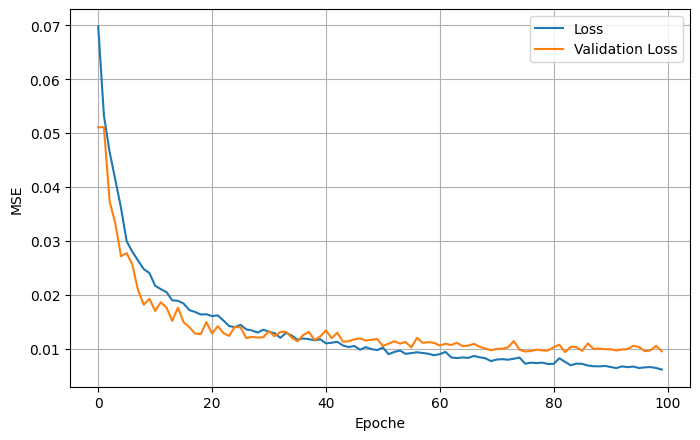

In [4]:
dnn_model_11522500 = model.model_CNN_LSTM(forcings_11522500.shape[1],forcings_11522500.shape[2],forcings_11522500.shape[3],
                                        forcings_11522500.shape[4])

history = model.kompilierung(model=dnn_model_11522500, inputs=forcings_11522500_train, targets=streamflow_11522500_train,
                          validation=(forcings_11522500_eval, streamflow_11522500_eval), batch_size=64, epochs=100)

model.loss(history)


# Evaluierung und Speichern der Metriken
dnn_results_11522500 = dnn_model_11522500.evaluate(forcings_11522500_test, streamflow_11522500_test)
# Vorhersage der auf den Testdaten
y_predicted_11522500 = dnn_model_11522500.predict(forcings_11522500_test)

### Seattle CNNLSTM

Epoch 1/100
63/63 [==============================] - 36s 571ms/step - loss: 0.0860 - mean_squared_error: 0.0860 - mean_absolute_error: 0.2328 - val_loss: 0.0666 - val_mean_squared_error: 0.0666 - val_mean_absolute_error: 0.2120
Epoch 2/100
63/63 [==============================] - 11s 176ms/step - loss: 0.0639 - mean_squared_error: 0.0639 - mean_absolute_error: 0.1975 - val_loss: 0.0595 - val_mean_squared_error: 0.0596 - val_mean_absolute_error: 0.1876
Epoch 3/100
63/63 [==============================] - 21s 337ms/step - loss: 0.0584 - mean_squared_error: 0.0584 - mean_absolute_error: 0.1874 - val_loss: 0.0550 - val_mean_squared_error: 0.0551 - val_mean_absolute_error: 0.1842
Epoch 4/100
63/63 [==============================] - 10s 151ms/step - loss: 0.0531 - mean_squared_error: 0.0531 - mean_absolute_error: 0.1774 - val_loss: 0.0499 - val_mean_squared_error: 0.0500 - val_mean_absolute_error: 0.1778
Epoch 5/100
63/63 [==============================] - 9s 141ms/step - loss: 0.0492 - mean

Epoch 37/100
63/63 [==============================] - 9s 139ms/step - loss: 0.0163 - mean_squared_error: 0.0163 - mean_absolute_error: 0.0947 - val_loss: 0.0163 - val_mean_squared_error: 0.0164 - val_mean_absolute_error: 0.0937
Epoch 38/100
63/63 [==============================] - 9s 140ms/step - loss: 0.0160 - mean_squared_error: 0.0160 - mean_absolute_error: 0.0925 - val_loss: 0.0180 - val_mean_squared_error: 0.0179 - val_mean_absolute_error: 0.0987
Epoch 39/100
63/63 [==============================] - 9s 137ms/step - loss: 0.0176 - mean_squared_error: 0.0176 - mean_absolute_error: 0.0977 - val_loss: 0.0188 - val_mean_squared_error: 0.0188 - val_mean_absolute_error: 0.1013
Epoch 40/100
63/63 [==============================] - 9s 137ms/step - loss: 0.0152 - mean_squared_error: 0.0152 - mean_absolute_error: 0.0908 - val_loss: 0.0170 - val_mean_squared_error: 0.0170 - val_mean_absolute_error: 0.0960
Epoch 41/100
63/63 [==============================] - 9s 136ms/step - loss: 0.0148 - mea

Epoch 73/100
63/63 [==============================] - 10s 166ms/step - loss: 0.0115 - mean_squared_error: 0.0115 - mean_absolute_error: 0.0780 - val_loss: 0.0139 - val_mean_squared_error: 0.0139 - val_mean_absolute_error: 0.0864
Epoch 74/100
63/63 [==============================] - 10s 166ms/step - loss: 0.0112 - mean_squared_error: 0.0112 - mean_absolute_error: 0.0781 - val_loss: 0.0162 - val_mean_squared_error: 0.0161 - val_mean_absolute_error: 0.0910
Epoch 75/100
63/63 [==============================] - 13s 209ms/step - loss: 0.0106 - mean_squared_error: 0.0106 - mean_absolute_error: 0.0757 - val_loss: 0.0159 - val_mean_squared_error: 0.0158 - val_mean_absolute_error: 0.0914
Epoch 76/100
63/63 [==============================] - 14s 225ms/step - loss: 0.0113 - mean_squared_error: 0.0113 - mean_absolute_error: 0.0782 - val_loss: 0.0150 - val_mean_squared_error: 0.0150 - val_mean_absolute_error: 0.0882
Epoch 77/100
63/63 [==============================] - 11s 170ms/step - loss: 0.0104 

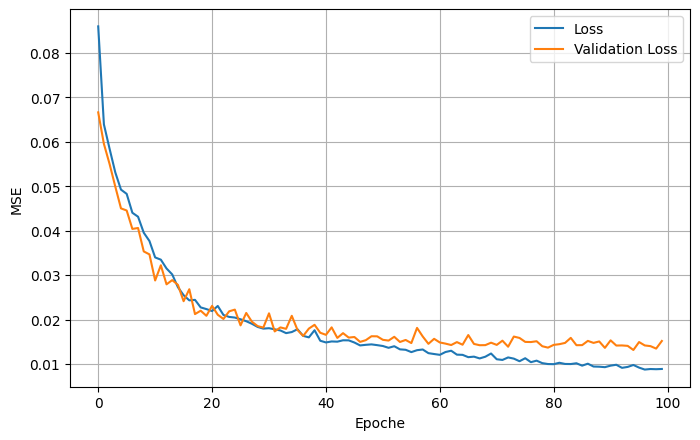

In [5]:
dnn_model_12189500 = model.model_CNN_LSTM(forcings_12189500.shape[1],forcings_12189500.shape[2],forcings_12189500.shape[3],
                                        forcings_12189500.shape[4])

history = model.kompilierung(model=dnn_model_12189500, inputs=forcings_12189500_train, targets=streamflow_12189500_train,
                          validation=(forcings_12189500_eval, streamflow_12189500_eval), batch_size=64, epochs=100)

model.loss(history)


# Evaluierung und Speichern der Metriken
dnn_results_12189500 = dnn_model_12189500.evaluate(forcings_12189500_test, streamflow_12189500_test)
# Vorhersage der auf den Testdaten
y_predicted_12189500 = dnn_model_12189500.predict(forcings_12189500_test)


## Load Camels US Dataset for LSTM
#### Loading the downloaded Camels-US  streamflow/forcing data and preprocess these. Daymet and Camels Dataset are differently build up. In this constellation the traindata includes 80% of the whole dataset. The evaluation and test dataset each include 10% of the whole dataset. In this case data from 1980 to 1996 is considered but can be changed by changing the start- and endyear variables. 50 days are used here to calculate the streamflow on day 50+1. Changing "days" for example to 30 would calculate the streamflow on day 30+1.

In [4]:
basin = ["09494000","11522500","12189500"] # Areas to consider

start_date="80-01-01" # startdate: YY-MM-DD
end_date="95-12-31" # enddate: YY-MM-DD
days=50 # Days to consider

forcing,streamflow = getData.lstm_data(basin,start_date, end_date,days) # load data 

# Normalization
forcing_LSTM_9494000, SF_LSTM_forcing_9494000 = preProcess.scale(forcing[0])
streamflow_LSTM_9494000, SF_LSTM_streamflow_9494000 = preProcess.scale(streamflow[0])
forcing_LSTM_9494000,streamflow_LSTM_9494000 = preProcess.prepareTensor(forcing_LSTM_9494000,streamflow_LSTM_9494000,days)
forcing_LSTM_9494000,streamflow_LSTM_9494000 = preProcess.shuffle(forcing_LSTM_9494000,streamflow_LSTM_9494000)

forcing_LSTM_11522500, SF_LSTM_forcing_11522500 = preProcess.scale(forcing[1])
streamflow_LSTM_11522500, SF_LSTM_streamflow_11522500 = preProcess.scale(streamflow[1])
forcing_LSTM_11522500,streamflow_LSTM_11522500 = preProcess.prepareTensor(forcing_LSTM_11522500,streamflow_LSTM_11522500,days)
forcing_LSTM_11522500,streamflow_LSTM_11522500 = preProcess.shuffle(forcing_LSTM_11522500,streamflow_LSTM_11522500)

forcing_LSTM_12189500, SF_LSTM_forcing_12189500 = preProcess.scale(forcing[2])
streamflow_LSTM_12189500, SF_LSTM_streamflow_12189500 = preProcess.scale(streamflow[2])
forcing_LSTM_12189500,streamflow_LSTM_12189500 = preProcess.prepareTensor(forcing_LSTM_12189500,streamflow_LSTM_12189500,days)
forcing_LSTM_12189500,streamflow_LSTM_12189500 = preProcess.shuffle(forcing_LSTM_12189500,streamflow_LSTM_12189500)

# Traindata
forcing_LSTM_9494000_train = forcing_LSTM_9494000[:round(len(forcing_LSTM_9494000)*0.8)]
streamflow_LSTM_9494000_train = streamflow_LSTM_9494000[:round(len(streamflow_LSTM_9494000)*0.8)]

forcing_LSTM_11522500_train = forcing_LSTM_11522500[:round(len(forcing_LSTM_11522500)*0.8)]
streamflow_LSTM_11522500_train = streamflow_LSTM_11522500[:round(len(streamflow_LSTM_11522500)*0.8)]

forcing_LSTM_12189500_train = forcing_LSTM_12189500[:round(len(forcing_LSTM_12189500)*0.8)]
streamflow_LSTM_12189500_train = streamflow_LSTM_12189500[:round(len(streamflow_LSTM_12189500)*0.8)]

# Evaldata
forcing_LSTM_9494000_eval= forcing_LSTM_9494000[round(len(forcing_LSTM_9494000)*0.8):round(len(forcing_LSTM_9494000)*0.9)]
streamflow_LSTM_9494000_eval= streamflow_LSTM_9494000[round(len(streamflow_LSTM_9494000)*0.8):round(len(streamflow_LSTM_9494000)*0.9)]

forcing_LSTM_11522500_eval= forcing_LSTM_11522500[round(len(forcing_LSTM_11522500)*0.8):round(len(forcing_LSTM_11522500)*0.9)]
streamflow_LSTM_11522500_eval= streamflow_LSTM_11522500[round(len(streamflow_LSTM_11522500)*0.8):round(len(streamflow_LSTM_11522500)*0.9)]

forcing_LSTM_12189500_eval= forcing_LSTM_12189500[round(len(forcing_LSTM_12189500)*0.8):round(len(forcing_LSTM_12189500)*0.9)]
streamflow_LSTM_12189500_eval= streamflow_LSTM_12189500[round(len(streamflow_LSTM_12189500)*0.8):round(len(streamflow_LSTM_12189500)*0.9)]

# Testdata
forcing_LSTM_9494000_test= forcing_LSTM_9494000[round(len(forcing_LSTM_9494000)*0.9):]
streamflow_LSTM_9494000_test= streamflow_LSTM_9494000[round(len(streamflow_LSTM_9494000)*0.9):]

forcing_LSTM_11522500_test= forcing_LSTM_11522500[round(len(forcing_LSTM_11522500)*0.9):]
streamflow_LSTM_11522500_test= streamflow_LSTM_11522500[round(len(streamflow_LSTM_11522500)*0.9):]

forcing_LSTM_12189500_test= forcing_LSTM_12189500[round(len(forcing_LSTM_12189500)*0.9):]
streamflow_LSTM_12189500_test= streamflow_LSTM_12189500[round(len(streamflow_LSTM_12189500)*0.9):]


### Mesa LSTM

Epoch 1/200
73/73 [==============================] - 2s 23ms/step - loss: 0.0029 - mean_squared_error: 0.0029 - mean_absolute_error: 0.0335 - val_loss: 0.0014 - val_mean_squared_error: 0.0016 - val_mean_absolute_error: 0.0235
Epoch 2/200
73/73 [==============================] - 1s 11ms/step - loss: 0.0018 - mean_squared_error: 0.0018 - mean_absolute_error: 0.0237 - val_loss: 0.0010 - val_mean_squared_error: 0.0012 - val_mean_absolute_error: 0.0189
Epoch 3/200
73/73 [==============================] - 1s 12ms/step - loss: 0.0016 - mean_squared_error: 0.0016 - mean_absolute_error: 0.0212 - val_loss: 9.9422e-04 - val_mean_squared_error: 0.0012 - val_mean_absolute_error: 0.0164
Epoch 4/200
73/73 [==============================] - 1s 13ms/step - loss: 0.0015 - mean_squared_error: 0.0015 - mean_absolute_error: 0.0194 - val_loss: 0.0010 - val_mean_squared_error: 0.0012 - val_mean_absolute_error: 0.0189
Epoch 5/200
73/73 [==============================] - 1s 11ms/step - loss: 0.0015 - mean_squa

Epoch 70/200
73/73 [==============================] - 1s 11ms/step - loss: 6.2335e-04 - mean_squared_error: 6.2982e-04 - mean_absolute_error: 0.0142 - val_loss: 9.4962e-04 - val_mean_squared_error: 9.2250e-04 - val_mean_absolute_error: 0.0151
Epoch 71/200
73/73 [==============================] - 1s 12ms/step - loss: 6.3534e-04 - mean_squared_error: 6.3752e-04 - mean_absolute_error: 0.0140 - val_loss: 0.0010 - val_mean_squared_error: 0.0011 - val_mean_absolute_error: 0.0138
Epoch 72/200
73/73 [==============================] - 1s 11ms/step - loss: 6.1607e-04 - mean_squared_error: 6.1288e-04 - mean_absolute_error: 0.0136 - val_loss: 0.0010 - val_mean_squared_error: 9.8911e-04 - val_mean_absolute_error: 0.0146
Epoch 73/200
73/73 [==============================] - 1s 11ms/step - loss: 6.9376e-04 - mean_squared_error: 6.9276e-04 - mean_absolute_error: 0.0150 - val_loss: 9.9957e-04 - val_mean_squared_error: 9.1961e-04 - val_mean_absolute_error: 0.0162
Epoch 74/200
73/73 [====================

73/73 [==============================] - 1s 10ms/step - loss: 2.2056e-04 - mean_squared_error: 2.1982e-04 - mean_absolute_error: 0.0089 - val_loss: 4.4296e-04 - val_mean_squared_error: 4.2781e-04 - val_mean_absolute_error: 0.0089
Epoch 139/200
73/73 [==============================] - 1s 10ms/step - loss: 1.9282e-04 - mean_squared_error: 1.9218e-04 - mean_absolute_error: 0.0085 - val_loss: 5.9148e-04 - val_mean_squared_error: 5.6760e-04 - val_mean_absolute_error: 0.0102
Epoch 140/200
73/73 [==============================] - 1s 10ms/step - loss: 2.2842e-04 - mean_squared_error: 2.2818e-04 - mean_absolute_error: 0.0088 - val_loss: 5.9397e-04 - val_mean_squared_error: 5.6046e-04 - val_mean_absolute_error: 0.0105
Epoch 141/200
73/73 [==============================] - 1s 11ms/step - loss: 2.4547e-04 - mean_squared_error: 2.4565e-04 - mean_absolute_error: 0.0091 - val_loss: 4.6546e-04 - val_mean_squared_error: 4.4661e-04 - val_mean_absolute_error: 0.0105
Epoch 142/200
73/73 [=================

Epoch 172/200
73/73 [==============================] - 1s 11ms/step - loss: 2.5604e-04 - mean_squared_error: 2.5490e-04 - mean_absolute_error: 0.0095 - val_loss: 2.9811e-04 - val_mean_squared_error: 2.8866e-04 - val_mean_absolute_error: 0.0092
Epoch 173/200
73/73 [==============================] - 1s 11ms/step - loss: 1.2627e-04 - mean_squared_error: 1.2561e-04 - mean_absolute_error: 0.0068 - val_loss: 3.3730e-04 - val_mean_squared_error: 3.1637e-04 - val_mean_absolute_error: 0.0087
Epoch 174/200
73/73 [==============================] - 1s 11ms/step - loss: 1.3206e-04 - mean_squared_error: 1.3126e-04 - mean_absolute_error: 0.0071 - val_loss: 3.6159e-04 - val_mean_squared_error: 3.3078e-04 - val_mean_absolute_error: 0.0083
Epoch 175/200
73/73 [==============================] - 1s 11ms/step - loss: 1.1143e-04 - mean_squared_error: 1.1122e-04 - mean_absolute_error: 0.0064 - val_loss: 3.1149e-04 - val_mean_squared_error: 2.9113e-04 - val_mean_absolute_error: 0.0077
Epoch 176/200
73/73 [===

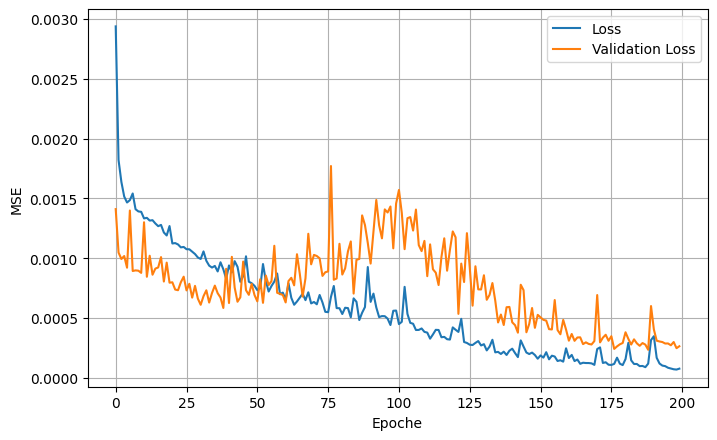

In [3]:
dnn_model_LSTM_9494000 = model.model_LSTM(forcing_LSTM_9494000.shape[1],forcing_LSTM_9494000.shape[2])

# Bauen und Trainieren des NNs
history = model.kompilierung(model=dnn_model_LSTM_9494000, inputs=forcing_LSTM_9494000_train, targets=streamflow_LSTM_9494000_train,
                          validation=(forcing_LSTM_9494000_eval, streamflow_LSTM_9494000_eval), batch_size=64, epochs=200)

model.loss(history)


# Evaluierung und Speichern der Metriken
result_9494000_LSTM = dnn_model_LSTM_9494000.evaluate(forcing_LSTM_9494000_test, streamflow_LSTM_9494000_test)
# Vorhersage der auf den Testdaten
y_predicted_9494000_LSTM = dnn_model_LSTM_9494000.predict(forcing_LSTM_9494000_test)

### Eureka LSTM

Epoch 1/200
73/73 [==============================] - 1s 20ms/step - loss: 0.0041 - mean_squared_error: 0.0041 - mean_absolute_error: 0.0387 - val_loss: 0.0042 - val_mean_squared_error: 0.0040 - val_mean_absolute_error: 0.0386
Epoch 2/200
73/73 [==============================] - 1s 8ms/step - loss: 0.0030 - mean_squared_error: 0.0030 - mean_absolute_error: 0.0318 - val_loss: 0.0038 - val_mean_squared_error: 0.0035 - val_mean_absolute_error: 0.0302
Epoch 3/200
73/73 [==============================] - 1s 8ms/step - loss: 0.0027 - mean_squared_error: 0.0027 - mean_absolute_error: 0.0293 - val_loss: 0.0034 - val_mean_squared_error: 0.0032 - val_mean_absolute_error: 0.0270
Epoch 4/200
73/73 [==============================] - 1s 8ms/step - loss: 0.0025 - mean_squared_error: 0.0025 - mean_absolute_error: 0.0269 - val_loss: 0.0035 - val_mean_squared_error: 0.0033 - val_mean_absolute_error: 0.0331
Epoch 5/200
73/73 [==============================] - 1s 8ms/step - loss: 0.0024 - mean_squared_erro

73/73 [==============================] - 1s 8ms/step - loss: 6.3720e-04 - mean_squared_error: 6.3414e-04 - mean_absolute_error: 0.0140 - val_loss: 0.0011 - val_mean_squared_error: 9.9401e-04 - val_mean_absolute_error: 0.0161
Epoch 73/200
73/73 [==============================] - 1s 8ms/step - loss: 6.6381e-04 - mean_squared_error: 6.6013e-04 - mean_absolute_error: 0.0142 - val_loss: 0.0011 - val_mean_squared_error: 0.0010 - val_mean_absolute_error: 0.0143
Epoch 74/200
73/73 [==============================] - 1s 8ms/step - loss: 6.2802e-04 - mean_squared_error: 6.2466e-04 - mean_absolute_error: 0.0136 - val_loss: 9.4612e-04 - val_mean_squared_error: 8.7106e-04 - val_mean_absolute_error: 0.0148
Epoch 75/200
73/73 [==============================] - 1s 8ms/step - loss: 5.9362e-04 - mean_squared_error: 5.9522e-04 - mean_absolute_error: 0.0132 - val_loss: 9.1954e-04 - val_mean_squared_error: 8.4257e-04 - val_mean_absolute_error: 0.0145
Epoch 76/200
73/73 [==============================] - 1s 

73/73 [==============================] - 1s 8ms/step - loss: 4.3567e-04 - mean_squared_error: 4.3679e-04 - mean_absolute_error: 0.0112 - val_loss: 8.9923e-04 - val_mean_squared_error: 8.2359e-04 - val_mean_absolute_error: 0.0122
Epoch 107/200
73/73 [==============================] - 1s 8ms/step - loss: 3.9826e-04 - mean_squared_error: 3.9715e-04 - mean_absolute_error: 0.0109 - val_loss: 8.9562e-04 - val_mean_squared_error: 8.1439e-04 - val_mean_absolute_error: 0.0124
Epoch 108/200
73/73 [==============================] - 1s 8ms/step - loss: 4.0613e-04 - mean_squared_error: 4.0415e-04 - mean_absolute_error: 0.0113 - val_loss: 9.4603e-04 - val_mean_squared_error: 8.5977e-04 - val_mean_absolute_error: 0.0124
Epoch 109/200
73/73 [==============================] - 1s 8ms/step - loss: 4.0447e-04 - mean_squared_error: 4.0302e-04 - mean_absolute_error: 0.0110 - val_loss: 9.1932e-04 - val_mean_squared_error: 8.3474e-04 - val_mean_absolute_error: 0.0127
Epoch 110/200
73/73 [=====================

Epoch 140/200
73/73 [==============================] - 1s 8ms/step - loss: 2.6692e-04 - mean_squared_error: 2.6580e-04 - mean_absolute_error: 0.0092 - val_loss: 8.4732e-04 - val_mean_squared_error: 7.6821e-04 - val_mean_absolute_error: 0.0114
Epoch 141/200
73/73 [==============================] - 1s 8ms/step - loss: 2.9169e-04 - mean_squared_error: 2.9036e-04 - mean_absolute_error: 0.0094 - val_loss: 8.5126e-04 - val_mean_squared_error: 7.7240e-04 - val_mean_absolute_error: 0.0121
Epoch 142/200
73/73 [==============================] - 1s 8ms/step - loss: 2.8413e-04 - mean_squared_error: 2.8307e-04 - mean_absolute_error: 0.0094 - val_loss: 8.8981e-04 - val_mean_squared_error: 8.1067e-04 - val_mean_absolute_error: 0.0123
Epoch 143/200
73/73 [==============================] - 1s 8ms/step - loss: 2.5951e-04 - mean_squared_error: 2.5931e-04 - mean_absolute_error: 0.0086 - val_loss: 8.9208e-04 - val_mean_squared_error: 8.0916e-04 - val_mean_absolute_error: 0.0123
Epoch 144/200
73/73 [=======

Epoch 174/200
73/73 [==============================] - 1s 8ms/step - loss: 2.2247e-04 - mean_squared_error: 2.2176e-04 - mean_absolute_error: 0.0081 - val_loss: 9.3543e-04 - val_mean_squared_error: 8.4978e-04 - val_mean_absolute_error: 0.0124
Epoch 175/200
73/73 [==============================] - 1s 8ms/step - loss: 2.2969e-04 - mean_squared_error: 2.4404e-04 - mean_absolute_error: 0.0084 - val_loss: 8.8046e-04 - val_mean_squared_error: 8.0104e-04 - val_mean_absolute_error: 0.0120
Epoch 176/200
73/73 [==============================] - 1s 8ms/step - loss: 3.6385e-04 - mean_squared_error: 3.6316e-04 - mean_absolute_error: 0.0108 - val_loss: 8.5695e-04 - val_mean_squared_error: 7.7990e-04 - val_mean_absolute_error: 0.0111
Epoch 177/200
73/73 [==============================] - 1s 8ms/step - loss: 2.4141e-04 - mean_squared_error: 2.4137e-04 - mean_absolute_error: 0.0086 - val_loss: 0.0011 - val_mean_squared_error: 9.5596e-04 - val_mean_absolute_error: 0.0117
Epoch 178/200
73/73 [===========

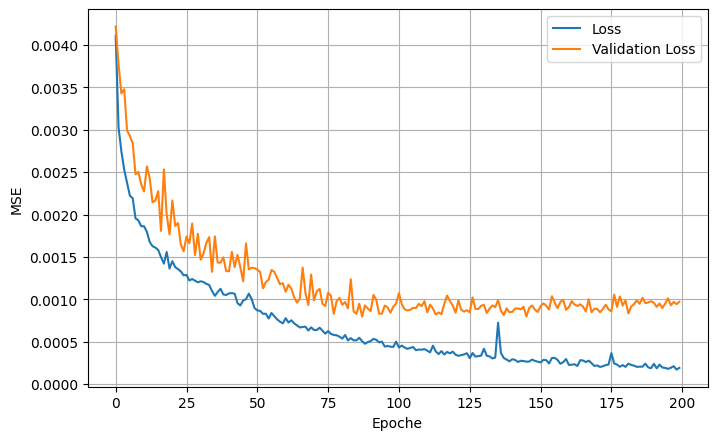

In [10]:
dnn_model_LSTM_11522500 = model.model_LSTM(forcing_LSTM_11522500.shape[1],forcing_LSTM_11522500.shape[2])
# Bauen und Trainieren des NNs
history = model.kompilierung(model=dnn_model_LSTM_11522500, inputs=forcing_LSTM_11522500_train, targets=streamflow_LSTM_11522500_train,
                          validation=(forcing_LSTM_11522500_eval, streamflow_LSTM_11522500_eval), batch_size=64, epochs=200)

model.loss(history)


# Evaluierung und Speichern der Metriken
result_11522500_LSTM = dnn_model_LSTM_11522500.evaluate(forcing_LSTM_11522500_test, streamflow_LSTM_11522500_test)
# Vorhersage der auf den Testdaten
y_predicted_11522500_LSTM = dnn_model_LSTM_11522500.predict(forcing_LSTM_11522500_test)


### Seattle LSTM

Epoch 1/200
73/73 [==============================] - 2s 32ms/step - loss: 0.0028 - mean_squared_error: 0.0028 - mean_absolute_error: 0.0313 - val_loss: 0.0017 - val_mean_squared_error: 0.0016 - val_mean_absolute_error: 0.0286
Epoch 2/200
73/73 [==============================] - 1s 8ms/step - loss: 0.0024 - mean_squared_error: 0.0024 - mean_absolute_error: 0.0266 - val_loss: 0.0016 - val_mean_squared_error: 0.0014 - val_mean_absolute_error: 0.0261
Epoch 3/200
73/73 [==============================] - 1s 8ms/step - loss: 0.0022 - mean_squared_error: 0.0022 - mean_absolute_error: 0.0247 - val_loss: 0.0016 - val_mean_squared_error: 0.0015 - val_mean_absolute_error: 0.0321
Epoch 4/200
73/73 [==============================] - 1s 8ms/step - loss: 0.0021 - mean_squared_error: 0.0021 - mean_absolute_error: 0.0248 - val_loss: 0.0011 - val_mean_squared_error: 0.0011 - val_mean_absolute_error: 0.0228
Epoch 5/200
73/73 [==============================] - 1s 8ms/step - loss: 0.0019 - mean_squared_erro

Epoch 36/200
73/73 [==============================] - 1s 8ms/step - loss: 8.4823e-04 - mean_squared_error: 8.4295e-04 - mean_absolute_error: 0.0169 - val_loss: 5.7761e-04 - val_mean_squared_error: 5.5736e-04 - val_mean_absolute_error: 0.0152
Epoch 37/200
73/73 [==============================] - 1s 8ms/step - loss: 8.8281e-04 - mean_squared_error: 8.8201e-04 - mean_absolute_error: 0.0162 - val_loss: 8.3608e-04 - val_mean_squared_error: 7.9979e-04 - val_mean_absolute_error: 0.0187
Epoch 38/200
73/73 [==============================] - 1s 8ms/step - loss: 9.9780e-04 - mean_squared_error: 9.9330e-04 - mean_absolute_error: 0.0183 - val_loss: 5.6391e-04 - val_mean_squared_error: 5.4907e-04 - val_mean_absolute_error: 0.0160
Epoch 39/200
73/73 [==============================] - 1s 8ms/step - loss: 8.6256e-04 - mean_squared_error: 8.5724e-04 - mean_absolute_error: 0.0161 - val_loss: 5.4639e-04 - val_mean_squared_error: 5.2481e-04 - val_mean_absolute_error: 0.0149
Epoch 40/200
73/73 [============

Epoch 70/200
73/73 [==============================] - 1s 8ms/step - loss: 6.2252e-04 - mean_squared_error: 6.2202e-04 - mean_absolute_error: 0.0140 - val_loss: 8.0054e-04 - val_mean_squared_error: 7.7856e-04 - val_mean_absolute_error: 0.0183
Epoch 71/200
73/73 [==============================] - 1s 8ms/step - loss: 6.1558e-04 - mean_squared_error: 6.1306e-04 - mean_absolute_error: 0.0149 - val_loss: 5.9816e-04 - val_mean_squared_error: 5.8900e-04 - val_mean_absolute_error: 0.0142
Epoch 72/200
73/73 [==============================] - 1s 8ms/step - loss: 5.8774e-04 - mean_squared_error: 5.8588e-04 - mean_absolute_error: 0.0139 - val_loss: 5.9362e-04 - val_mean_squared_error: 5.6183e-04 - val_mean_absolute_error: 0.0144
Epoch 73/200
73/73 [==============================] - 1s 8ms/step - loss: 6.2321e-04 - mean_squared_error: 6.2071e-04 - mean_absolute_error: 0.0145 - val_loss: 7.9198e-04 - val_mean_squared_error: 7.4393e-04 - val_mean_absolute_error: 0.0170
Epoch 74/200
73/73 [============

Epoch 104/200
73/73 [==============================] - 1s 8ms/step - loss: 4.2382e-04 - mean_squared_error: 4.2810e-04 - mean_absolute_error: 0.0130 - val_loss: 7.4145e-04 - val_mean_squared_error: 6.7590e-04 - val_mean_absolute_error: 0.0150
Epoch 105/200
73/73 [==============================] - 1s 7ms/step - loss: 3.6109e-04 - mean_squared_error: 3.6109e-04 - mean_absolute_error: 0.0123 - val_loss: 7.1610e-04 - val_mean_squared_error: 6.6291e-04 - val_mean_absolute_error: 0.0153
Epoch 106/200
73/73 [==============================] - 1s 8ms/step - loss: 3.3494e-04 - mean_squared_error: 3.4028e-04 - mean_absolute_error: 0.0119 - val_loss: 6.1047e-04 - val_mean_squared_error: 5.7335e-04 - val_mean_absolute_error: 0.0144
Epoch 107/200
73/73 [==============================] - 1s 8ms/step - loss: 3.4062e-04 - mean_squared_error: 3.3930e-04 - mean_absolute_error: 0.0117 - val_loss: 7.1447e-04 - val_mean_squared_error: 6.7501e-04 - val_mean_absolute_error: 0.0139
Epoch 108/200
73/73 [=======

Epoch 138/200
73/73 [==============================] - 1s 8ms/step - loss: 2.2842e-04 - mean_squared_error: 2.2903e-04 - mean_absolute_error: 0.0100 - val_loss: 8.7336e-04 - val_mean_squared_error: 8.0306e-04 - val_mean_absolute_error: 0.0134
Epoch 139/200
73/73 [==============================] - 1s 8ms/step - loss: 2.4428e-04 - mean_squared_error: 2.4564e-04 - mean_absolute_error: 0.0103 - val_loss: 6.1974e-04 - val_mean_squared_error: 5.7483e-04 - val_mean_absolute_error: 0.0131
Epoch 140/200
73/73 [==============================] - 1s 8ms/step - loss: 2.5044e-04 - mean_squared_error: 2.5147e-04 - mean_absolute_error: 0.0103 - val_loss: 9.2999e-04 - val_mean_squared_error: 8.5022e-04 - val_mean_absolute_error: 0.0145
Epoch 141/200
73/73 [==============================] - 1s 8ms/step - loss: 2.5420e-04 - mean_squared_error: 2.5400e-04 - mean_absolute_error: 0.0105 - val_loss: 7.1383e-04 - val_mean_squared_error: 6.5488e-04 - val_mean_absolute_error: 0.0132
Epoch 142/200
73/73 [=======

Epoch 172/200
73/73 [==============================] - 1s 8ms/step - loss: 1.6374e-04 - mean_squared_error: 1.6371e-04 - mean_absolute_error: 0.0085 - val_loss: 8.5425e-04 - val_mean_squared_error: 7.8161e-04 - val_mean_absolute_error: 0.0125
Epoch 173/200
73/73 [==============================] - 1s 8ms/step - loss: 2.7397e-04 - mean_squared_error: 2.7304e-04 - mean_absolute_error: 0.0100 - val_loss: 8.3672e-04 - val_mean_squared_error: 7.6882e-04 - val_mean_absolute_error: 0.0137
Epoch 174/200
73/73 [==============================] - 1s 8ms/step - loss: 3.3170e-04 - mean_squared_error: 3.3154e-04 - mean_absolute_error: 0.0113 - val_loss: 6.5155e-04 - val_mean_squared_error: 6.1087e-04 - val_mean_absolute_error: 0.0128
Epoch 175/200
73/73 [==============================] - 1s 8ms/step - loss: 1.9721e-04 - mean_squared_error: 1.9658e-04 - mean_absolute_error: 0.0093 - val_loss: 8.0758e-04 - val_mean_squared_error: 7.4089e-04 - val_mean_absolute_error: 0.0126
Epoch 176/200
73/73 [=======

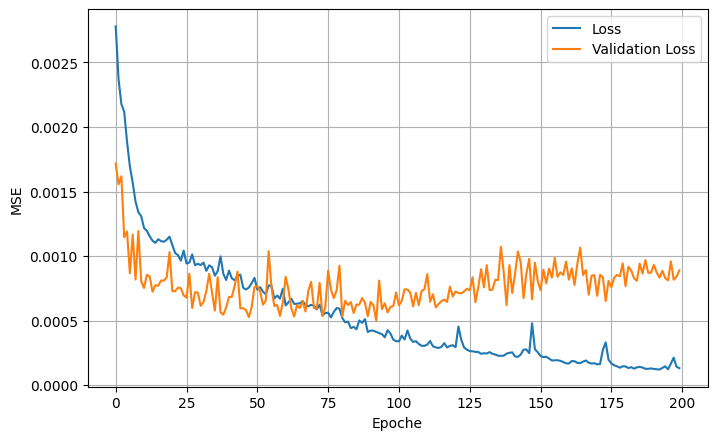

In [11]:
dnn_model_LSTM_12189500 = model.model_LSTM(forcing_LSTM_12189500.shape[1],forcing_LSTM_12189500.shape[2])

# Bauen und Trainieren des NNs
history = model.kompilierung(model=dnn_model_LSTM_12189500, inputs=forcing_LSTM_12189500_train, targets=streamflow_LSTM_12189500_train,
                          validation=(forcing_LSTM_12189500_eval, streamflow_LSTM_12189500_eval), batch_size=64, epochs=200)

model.loss(history)


# Evaluierung und Speichern der Metriken
result_12189500_LSTM = dnn_model_LSTM_12189500.evaluate(forcing_LSTM_12189500_test, streamflow_LSTM_12189500_test)
# Vorhersage der auf den Testdaten
y_predicted_12189500_LSTM = dnn_model_LSTM_12189500.predict(forcing_LSTM_12189500_test)


## Comparison of Nash–Sutcliffe model efficiency coefficient

Text(0.5, 1.0, 'Comparing of NSE value between LSTM and CNN-LSTM Models')

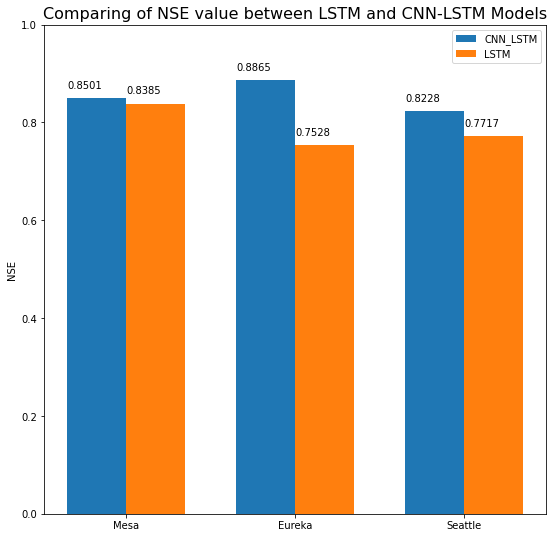

In [13]:
# NSE Berechnung
index=["Mesa","Eureka","Seattle"]

# CNNLSTM NSE
y_predicted_9494000_shaped=np.reshape(y_predicted_9494000,(y_predicted_9494000.shape[0],y_predicted_9494000.shape[1])) #Mesa
nse_9494000 = postProcess.nse(y_predicted_9494000_shaped, streamflow_9494000_test)#Mesa

y_predicted_11522500_shaped=np.reshape(y_predicted_11522500,(y_predicted_11522500.shape[0],y_predicted_11522500.shape[1]))#Eureka
nse_11522500 = postProcess.nse(y_predicted_11522500_shaped, streamflow_11522500_test)#Eureka

y_predicted_12189500_shaped=np.reshape(y_predicted_12189500,(y_predicted_12189500.shape[0],y_predicted_12189500.shape[1]))#Seattle
nse_12189500 = postProcess.nse(y_predicted_12189500_shaped, streamflow_12189500_test)#Seattle

# LSTM NSE
nse_9494000_LSTM = postProcess.nse(y_predicted_9494000_LSTM, streamflow_LSTM_9494000_test)#Mesa
nse_11522500_LSTM= postProcess.nse(y_predicted_11522500_LSTM, streamflow_LSTM_11522500_test)#Eureka
nse_12189500_LSTM = postProcess.nse(y_predicted_12189500_LSTM, streamflow_LSTM_12189500_test)#Seattle

nse_CNNLSTM = [nse_9494000,nse_11522500,nse_12189500]
nse_LSTM=[nse_9494000_LSTM,nse_11522500_LSTM,nse_12189500_LSTM]
x = np.arange(len(index)) 
width = 0.35 
fig, ax = plt.subplots(figsize=(9,9))
ax.bar(x , nse_CNNLSTM, width, label='CNN_LSTM')
ax.bar(x+width , nse_LSTM, width, label='LSTM')
ax.set_xticks(x+width/2)
ax.set_xticklabels(index)
plt.ylim(0,1)
for ind, value in enumerate(nse_CNNLSTM):
    plt.text(ind-width/2, value+0.02, str(round(value,4)))
for ind, value in enumerate(nse_LSTM):
    plt.text(ind+width/2, value+0.02, str(round(value,4)))
ax.legend()
plt.ylabel('NSE')
plt.title('Comparing of NSE value between LSTM and CNN-LSTM Models',fontsize=16)

## Comparison of real and predicted Streamflow

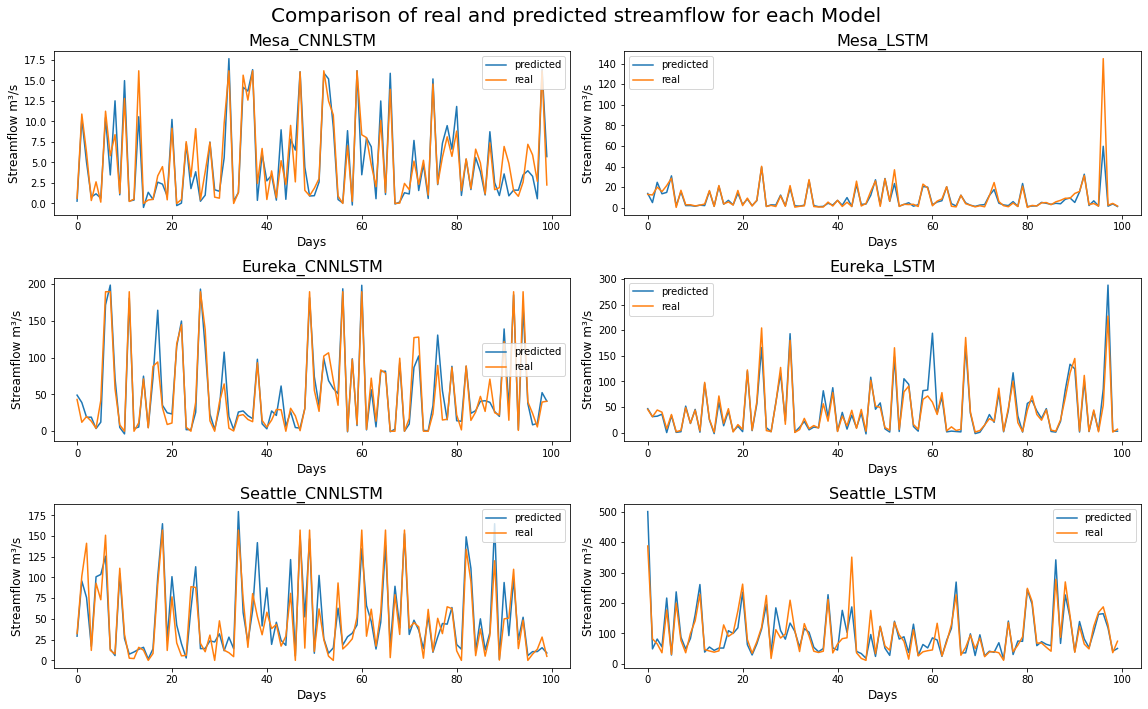

In [14]:
#CNNLSTM rescale Streamflow
y_9494000_simulated_real=y_predicted_9494000*SF_streamflow_9494000[0]
streamflow_9494000_test_real=streamflow_9494000_test*SF_streamflow_9494000[0]
y_11522500_simulated_real=y_predicted_11522500*SF_streamflow_11522500[0]
streamflow_11522500_test_real=streamflow_11522500_test*SF_streamflow_11522500[0]
y_12189500_simulated_real=y_predicted_12189500*SF_streamflow_12189500[0]
streamflow_12189500_test_real=streamflow_12189500_test*SF_streamflow_12189500[0]

#LSTM rescale Streamflow
y_9494000_LSTM_simulated=y_predicted_9494000_LSTM*SF_LSTM_streamflow_9494000
y_11522500_LSTM_simulated=y_predicted_11522500_LSTM*SF_LSTM_streamflow_11522500
y_12189500_LSTM_simulated=y_predicted_12189500_LSTM*SF_LSTM_streamflow_12189500
y_9494000_LSTM_real=streamflow_LSTM_9494000_test*SF_LSTM_streamflow_9494000
y_11522500_LSTM_real=streamflow_LSTM_11522500_test*SF_LSTM_streamflow_11522500
y_12189500_LSTM_real=streamflow_LSTM_12189500_test*SF_LSTM_streamflow_12189500


def xvalue(length):
    x =[]
    for i in range(length):
        x.append(i)
    return x
x_val = xvalue(y_9494000_simulated_real.shape[0])
x_50_val = xvalue(len(y_9494000_LSTM_simulated))

fig, ((ax1, ax2),(ax3,ax4),(ax5,ax6)) = plt.subplots(3, 2, figsize=(16,10))

# CNNLSTM Plot
ax1.plot(x_val[:100], y_9494000_simulated_real[:100], label="predicted") # Mesa
ax1.plot(x_val[:100], streamflow_9494000_test_real[:100], label="real")# Mesa
ax3.plot(x_val[:100], y_11522500_simulated_real[:100], label="predicted") #Eureka
ax3.plot(x_val[:100], streamflow_11522500_test_real[:100], label="real")#Eureka
ax5.plot(x_val[:100], y_12189500_simulated_real[:100], label="predicted")# Seattle
ax5.plot(x_val[:100], streamflow_12189500_test_real[:100], label="real")# Seattle
# CNNLSTM Title + Legend
ax1.legend(),ax1.set_title("Mesa_CNNLSTM", fontsize=16)
ax3.legend(),ax3.set_title("Eureka_CNNLSTM", fontsize=16)
ax5.legend(),ax5.set_title("Seattle_CNNLSTM", fontsize=16)

ax2.plot(x_50_val[:100], y_9494000_LSTM_simulated[:100], label="predicted")# Mesa
ax2.plot(x_50_val[:100], y_9494000_LSTM_real[:100], label="real")# Mesa
ax4.plot(x_50_val[:100], y_11522500_LSTM_simulated[:100], label="predicted")#Eureka
ax4.plot(x_50_val[:100], y_11522500_LSTM_real[:100], label="real")#Eureka
ax6.plot(x_50_val[:100], y_12189500_LSTM_simulated[:100], label="predicted") # Seattle
ax6.plot(x_50_val[:100], y_12189500_LSTM_real[:100], label="real")# Seattle
# LSTM Title + Legend
ax2.legend(),ax2.set_title("Mesa_LSTM", fontsize=16)
ax4.legend(),ax4.set_title("Eureka_LSTM", fontsize=16)
ax6.legend(),ax6.set_title("Seattle_LSTM", fontsize=16)

# Axes label
plt.suptitle('Comparison of real and predicted streamflow for each Model',fontsize=20)
axes=[ax1,ax2,ax3,ax4,ax5,ax6]
for ax in axes:
    ax.set_xlabel('Days', fontsize=12)
    ax.set_ylabel('Streamflow m³/s', fontsize=12)
plt.tight_layout()
